In [771]:
# import numpy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Credits: https://jonaslalin.com/2021/12/10/feedforward-neural-networks-part-1/#mjx-eqn%3Aeq%3Adz_scalar


In [999]:
# Create class 'Dense Layer', which represents a single layer of a neural network
class DenseLayer:
    def __init__(self, input_size, output_size, activation=None):
        np.random.seed(0)
        
        # Initialize weights and biases
        self.bias = np.random.randn(output_size,)

        # Initialize weights with He initialization
        self.weights = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
        self.activation = activation

        # Input is A^(l-1), output is A^(l), z is Z^(l)
        self.input = None
        self.z = None
        self.output = None

    def forward(self, input):
       """
       Compute the output of the layer given the input
       Shape of 
       input: (input,)  or (number of nodes in the previous layer,)
       weights: (output, input) or (nodes of current layer, nodes of previous layer)
       bias: (output,) or (nodes of current layer,)
       """
       self.input = input

       # z = Wx + broadcast(b)
       # a = activation(z)
       self.z = self.weights @ input + self.bias.reshape(-1,1)
       self.output = self.activation(self.z)
       return self.output
    
    def backward(self, dJ_da,lr):
        """
        Calculate gradient of output with respect to input, weights and bias
        Shape of
        d_output: (output, m) or (number of nodes in the current layer, number of samples)
        """
        dJ_dz = dJ_da * self.activation.backward(self.z)
        dJ_dw = dJ_dz @ self.input.T
        dJ_db = np.sum(dJ_dz, axis=1)

        self.weights -= lr*dJ_dw
        self.bias -= lr*dJ_db

        dJ_da_prev = self.weights.T @ dJ_dz

        # Return the gradient of the loss with respect to the input of the layer
        # Shape is (input, m)
        #print(f'Output Shape should be ({self.weights.shape[1]}, 1000)')
        #print(f'Output Shape is {dJ_da_prev.shape}')
        return dJ_da_prev
        

    

In [1096]:
class ActivationFunction:
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, x):
        raise NotImplementedError

class ReLU(ActivationFunction):
    def forward(self, x):
        return np.maximum(0, x)
    
    def backward(self, x):
        return np.where(x > 0, 1, 0)
    
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return  1 / (1 + np.exp(-x))
    
    def backward(self, x):
        return self.forward(x) * (1 - self.forward(x))
    
# DOuble check
class linear(ActivationFunction):
    def forward(self, x):
        return x
    
    def backward(self, x):
        return np.ones_like(x)

In [1017]:
class CostFunction:
    def __call__(self, y_true, y_pred):
        return self.forward(y_true, y_pred)
    
    def forward(self, y_true, y_pred):
        raise NotImplementedError
    
    def backward(self, y_true, y_pred):
        raise NotImplementedError
    

class MulticlassCrossEntrophy(CostFunction):
    """
    Cost function for multiclass classification
    shape of 
    """
    def forward(self, y_true, y_pred):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred)) / m
    
    def backward(self, y_true, y_pred):
        m = y_true.shape[0]

        # Returns dJ_dA^(L)
        return -1/m * (1/y_pred) * y_true

class BinaryCrossEntropy(CostFunction):
    """
    Cost function for binary classification
    Shape of
    y_true: (1, m) or (1, number of samples)
    y_pred: (1, m) or (1, number of samples)
    dj_dA: (1, m) or (1, number of samples)
    """
    def forward(self, y_true, y_pred):
        
        m = y_true.shape[1]
        epsilon = 1e-10
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)
        return -np.sum(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred), axis=1) / m
    
    def backward(self, y_true, y_pred):
        m = y_true.shape[1]

        # Returns dJ_dA^(L)
        return 1/m * (((1/(1-y_pred)) * (1-y_true)) - ((1/y_pred)* y_true))
    
# Mean Squared Error
class MeanSquaredError(CostFunction):
    def forward(self, y_true, y_pred):
        m = y_true.shape[1]

        return np.sum((y_true - y_pred)**2,axis=1) / m
    
    def backward(self, y_true, y_pred):
        m = y_true.shape[1]

        # Returns dJ_dA^(L)
        return 2 * (y_pred - y_true) / m
    

In [977]:
class FeedForwardNN:
    def __init__(self, is_debug=False):
        self.layers = []
        self.history = []

        # Debug mode prints out the shape of the input and output of each layer
        self.is_debug = is_debug

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, input):
        for i,layer in enumerate(self.layers):
            input = layer.forward(input)

            if self.is_debug:
                print('-'*10)
                print(f'Layer: {i+1}')
                print(f'Input Shape: {layer.input.shape}')
                print(f'Output Shape: {layer.output.shape}')
                print('-'*10)
        
        return input
    
    def backward(self, d_output, lr):

        layers_length = len(self.layers)

        for i,layer in enumerate(reversed(self.layers)):

                
            d_output = layer.backward(d_output, lr)

            if self.is_debug:
                print('='*10)
                print(f'Dj_da Layer: {layers_length - i}')
                print(f'Output Shape: {d_output.shape}')
                print('='*10)


    def train(self, X, y, epochs, lr, cost_fn):

        # Print out the shape of the input and output of each layer
        # ONLY FOR DEBUGGING
        if self.is_debug:
            print(f'X Shape: {X.shape}')
            print(f'y Shape: {y.shape}')
            print()

            y_pred = self.forward(X)
            print(f'y_pred Shape: {y_pred.shape}')
            print()

            cost = cost_fn(y, y_pred)
            print(f'Cost: {cost}, Cost Shape: {cost.shape}')
            print()

            dj_da = cost_fn.backward(y, y_pred)
            print(f'First dJ_dA Shape: {dj_da.shape}')
            self.backward(dj_da, lr)
            return
    
        for epoch in range(epochs):
            y_pred = self.forward(X)
            cost = cost_fn(y, y_pred)
            dj_da = cost_fn.backward(y, y_pred)
            self.backward(dj_da, lr)

            # Append cost[0] because cost is a 1x1 array
            self.history.append(cost[0])


        # Plot the cost function
        sns.lineplot(x=[i+1 for i in range(len(self.history))], y=self.history)
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title('Cost vs Epoch')
        plt.show()

    def predict(self, X):
        return self.forward(X)
    

In [1172]:
# Generate binary data
class bin_data:
    def __init__(self):
        self.X = None
        self.y = None

    def compute_y(self):
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape(-1).astype(int)

    def generate_data(self):
        self.X = np.random.randint(2, size=(1000,2))
        self.compute_y()
        return self.X, self.y
    
# Generate regression data
class reg_data:
    def __init__(self):
        self.X = None
        self.y = None
        self.X_norm = None
        self.y_norm = None
        self.mean = None
        self.std = None

    def compute_y(self):
        # y = x1*5 + x2(-20) + x3^2
        self.y = self.X[:,0]*5 + self.X[:,1]*20 + self.X[:,2]**2

    def generate_data(self):
        # Each training example has 3 features and 1 output(more than zero)
        feat1 = np.random.randint(10, size=(1000,1))
        feat2 = np.random.randint(1000, size=(1000,1))
        feat3 = np.random.randint(10000, size=(1000,1))
        self.X = np.concatenate((feat1,feat2,feat3), axis=1)
        self.compute_y()
        # Data has to be normalized to prevent gradient explosion
        self.normalize()
        return self.X_norm, self.y_norm
    
    def normalize(self):
        self.X_norm = (self.X - np.mean(self.X, axis=0)) / np.std(self.X, axis=0)
        self.y_norm = (self.y - np.mean(self.y)) / np.std(self.y)

        # Save mean and standard deviation of y
        self.mean, self.std = np.mean(self.y), np.std(self.y)


    
        



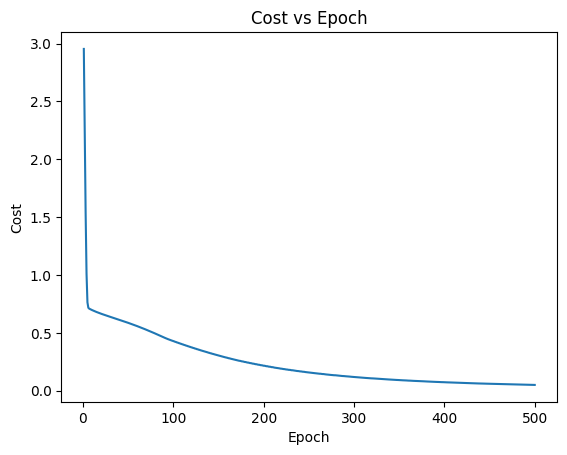

In [1128]:
XORdata = bin_data()
X, y = XORdata.generate_data()

nn = FeedForwardNN(is_debug=False)
nn.add_layer(DenseLayer(2, 10, ReLU()))
nn.add_layer(DenseLayer(10, 1, Sigmoid()))

# X need to be reshaped to (input, m) or (number of nodes in the previous layer, number of samples)
# y need to be reshaped to (1, m) or (1, number of samples)
nn.train(X.T, y.reshape(1,1000), 500, 0.1, BinaryCrossEntropy())


In [1129]:
# Test prediction
i = 1
y_pred = nn.predict(X[i].reshape(2,1))
y_pred = np.where(y_pred > 0.5, 1, 0)
print(f'Prediction: {y_pred.reshape(-1)}')
print(f'Actual: {y[i]}')


Prediction: [0]
Actual: 0


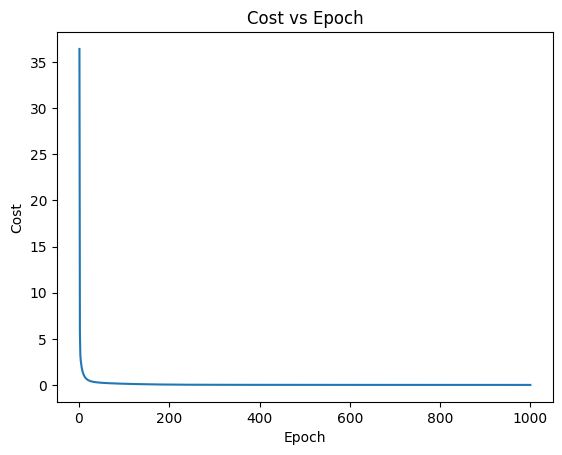

In [1189]:
# Predict values for non-negative regression data
regressionSample = reg_data()
X, y = regressionSample.generate_data()

nn2 = FeedForwardNN()
nn2.add_layer(DenseLayer(3, 10, ReLU()))
nn2.add_layer(DenseLayer(10, 10, ReLU()))
nn2.add_layer(DenseLayer(10, 1, linear()))

# X need to be reshaped to (input, m) or (number of nodes in the previous layer, number of samples)
# y need to be reshaped to (1, m) or (1, number of samples)
nn2.train(X.T, y.reshape(1,1000), 1000, 0.01, MeanSquaredError())
# nn2.train(X[1:3].reshape(3,-1), y[1:3].reshape(1,-1), 20, 0.000000001, MeanSquaredError())

In [1190]:
# Test prediction
i = 15
y_pred = nn2.predict(X[i].reshape(3,1))
y_pred = y_pred[0,0] * regressionSample.std + regressionSample.mean
y_true = y[i] * regressionSample.std + regressionSample.mean
print(f'Prediction: {y_pred}')
print(f'Actual: {y_true}')

Prediction: 78506528.99656354
Actual: 72282426.0
